# Export to Fibre Section

This example shows how to export a section to a fibre section that can be used in [suanPan](https://github.com/TLCFEM/suanPan).

[suanPan](https://github.com/TLCFEM/suanPan) is a finite element analysis framework. Sections can be exported and used to perform nonlinear analysis of frame structures.

There are three analysis types available.

1. '2D' ---> 2D planar analysis (axial force, bending moment). Elements: `B21`, `F21`.
2. '3D' ---> 3D spatial analysis (axial force, bending moment). Elements: `B31`, `F31`.
3. '3DOS' ---> 3D spatial analysis with warping and torsion (axial force, bending moment, torsion). Elements: `B31OS`.

The section is discretised into triangular elements in `sectionproperties`. Each triangle can be deemed as a small cell/fibre. Its area and properties at the centre of the triangle are calculated and exported to create a fibre section.

For '2D' and '3D' analyses, the location and area are used. For '3DOS' analysis, the additional warping function and its derivatives are used.

## The Export Function

One shall call the function with a geometry object with mesh created.

In [78]:
from sectionproperties.plugin.fibre import to_fibre_section
from sectionproperties.pre.library import i_section

geom = i_section(d=203, b=133, t_f=7.8, t_w=5.8, r=8.9, n_r=8)
geom.create_mesh(mesh_sizes=10)

commands = to_fibre_section(geom, analysis_type='3DOS')

print(commands[:3000])

# This is generated by sectionproperties library.
# Please note the following:
#   1. The warping function and its derivatives (if present) are computed in the
#      local coordinate system (about origin).
#   2. Beware of the potential different orientations of beam section.
#   3. It may be necessary to manually adjust the material tags.
#   4. If uncertain, please validate the behaviour first.
section Fibre3DOS 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 \
52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 \
105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 \
146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171

The output can be saved to a file and later be used to create beam elements.

In [79]:
from shutil import which

# write the fibre section to a file
with open('200UB25.4.sp', 'w') as f:
    f.write(commands)

# write the main analysis file
# since we assigned '3DOS' analysis type, we need to use compatible elements, for example, 'B31OS'.
model = '''# Example torsion analysis
node 1 0 0 0
node 2 1 0 0
material ElasticOS 1 200. .25
file 200UB25.4.sp
orientation B3DOSL 1 0. 0. 1.
element B31OS 1 1 2 1 1 6
fix2 1 E 1
displacement 1 0 1E-1 4 2
plainrecorder 1 Node RF4 2
step static 1
set ini_step_size 1E-1
set fixed_step_size true
converger RelIncreDisp 1 1E-10 5 1
analyze
save recorder 1
exit
'''
with open('torsion_analysis.sp', 'w') as f:
    f.write(model)

For further details, check [this](https://tlcfem.github.io/suanPan-manual/3.2/Example/Structural/Statics/thin-walled-section/) example.

## A Bit More Details

### Shift Section

As the header states, the function computes properties in the local coordinate system of the section.

For the above I-section, one may want to shift the section to the centroid of the section.
The user shall explicitly perform this step.

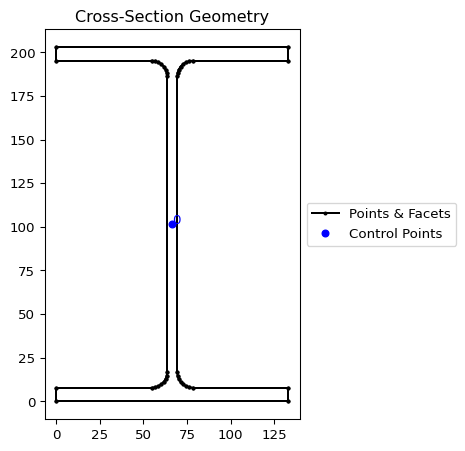

<Axes: title={'center': 'Cross-Section Geometry'}>

In [80]:
geom.plot_geometry()

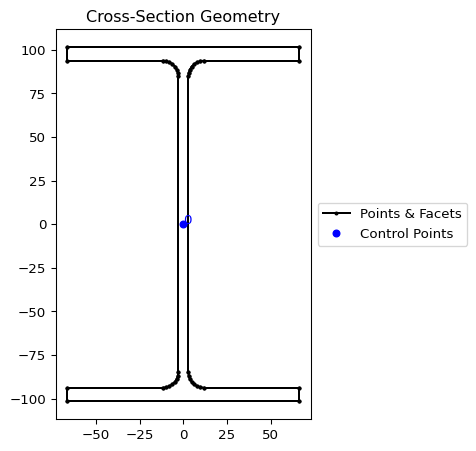

<Axes: title={'center': 'Cross-Section Geometry'}>

In [81]:
from sectionproperties.analysis import Section

sec = Section(geom)
sec.calculate_geometric_properties()
x, y = sec.get_c()
geom = geom.shift_section(-x, -y)  # or whatever shift you want
geom.create_mesh(mesh_sizes=5)
geom.plot_geometry()

### Overwrite Material

Material names shall be converted to material tags.

One can provide such a mapping dictionary to the function.
With the shifted geometry, one can do the following.

In [82]:
commands = to_fibre_section(geom, analysis_type='3DOS', material_mapping={'default': 1})
print(commands[:3000])

# This is generated by sectionproperties library.
# Please note the following:
#   1. The warping function and its derivatives (if present) are computed in the
#      local coordinate system (about origin).
#   2. Beware of the potential different orientations of beam section.
#   3. It may be necessary to manually adjust the material tags.
#   4. If uncertain, please validate the behaviour first.
section Fibre3DOS 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 \
52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 \
105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 \
146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171

## Run Analysis

If `suanPan` is installed, one can run the analysis using the previously saved script.

In [83]:
from os.path import exists

# write the fibre section to a file with material tag replaced
with open('200UB25.4.sp', 'w') as f:
    f.write(commands)

# run the analysis
if which('suanpan') is not None:
    from subprocess import run

    result_available = True
    run(['suanpan', '-f', 'torsion_analysis.sp'])
else:
    result_available = exists('R1-RF42.txt')
    print('suanPan is not installed.')

+-----------------------------------------------------+
|   __        __            suanPan is an open source |
|  /  \      |  \              FEM framework (64-bit) |
|  \__       |__/  __   __            Canopus (3.2.0) |
|     \ |  | |    |  \ |  |         by tlc @ d1fd9b9c |
|  \__/ |__| |    |__X |  |       all rights reserved |
|                              10.5281/zenodo.1285221 |
+-----------------------------------------------------+
|  🧮 https://github.com/TLCFEM/suanPan               |
|  📚 https://tlcfem.github.io/suanPan-manual/latest  |
+-----------------------------------------------------+
|  🎱 https://gitter.im/suanPan-dev/community         |
+-----------------------------------------------------+

>> Current Analysis Time: 0.10000.
--> Relative Incremental Displacement: 1.00000E+00.
--> Relative Incremental Displacement: 1.00000E+00.
--> Relative Incremental Displacement: 1.47340E-12.
>> Current Analysis Time: 0.20000.
--> Relative Incremental Displacement: 1.00000E+

## Plot Results

The result is stored in `R1-RF42.txt` (**R**ecorder **1** --> **RF4** for node **2**) file.

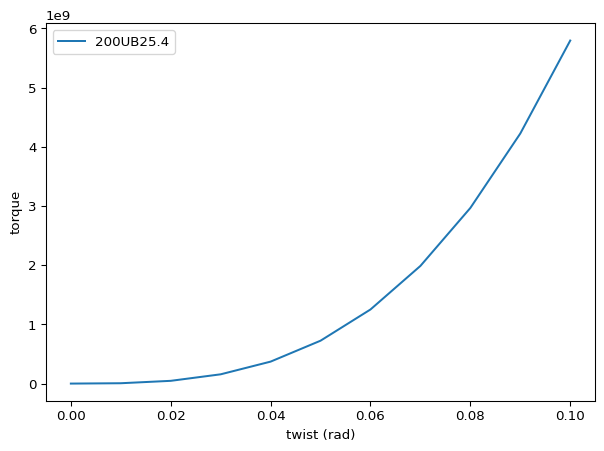

In [84]:

from matplotlib import pyplot as plt
import numpy as np

data = np.loadtxt('R1-RF42.txt')
twist = data[:, 0] * .1
torque = data[:, 1]
plt.plot(twist, torque)
plt.xlabel('twist (rad)')
plt.ylabel('torque')
plt.legend(['200UB25.4'])
plt.tight_layout()
plt.show()